<h1><b>A. Nhập</b></h1>

<h3><b>1. Tải các thư viên</b></h3>

In [81]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt 

<h3><b>2. Tải data

In [82]:
post_data = pd.read_csv('./dataset/csv_data/post_data.csv')
content_data = pd.read_csv('./dataset/csv_data/content_data.csv')
title_data = pd.read_csv('./dataset/csv_data/title_data.csv')

cleaned_data = pd.DataFrame() # Lưu kết quả cuối vào đây
# cleaned_data["url"] = post_data["url"]

cleaned_data['post_code'] = post_data['post_code']
cleaned_data['post_date'] = post_data['post_date']

cleaned_data["content"] = post_data["content"]
cleaned_data["title"] = post_data["title"]

cleaned_data["c_rent"] = content_data["rent"]
cleaned_data["t_rent"] = title_data["rent"]

cleaned_data["c_hurried"] = content_data["hurried"]
cleaned_data["t_hurried"] = title_data["hurried"]

cleaned_data["district"] = post_data["district"]

<h1><b>B. Replacing and Cleaning

Ở phần này, ta sẽ thay thế các data bị thiếu ở tập `main_data`, với thứ tự ưu tiên là `c_data` rồi `t_data`, vì các dữ liệu trong content sẽ được ghi chi tiết và đầy đủ hơn so với title.
Nếu như cả `c_data` và `t_data` đều trống, ta trả về `None` ở `main_data`

In [83]:
def replace_value(post, content, title):
    # Tạo màng gạt các giá trị null
    temp = content.copy()
    content_mask = content[(content.isnull()) | (content == 0)].index.values
    
    title = title.loc[content_mask]    
    title_mask = title[(title.isnull()) | (title == 0)].index.values

    title.loc[title_mask] = post.loc[title_mask]
    temp.loc[content_mask] = title.loc[content_mask]

    return temp

<h3><b>1. Price

Đối với giá tiền, trường hợp để trống dữ liệu sẽ không xảy ra, thay vào đó là "Thỏa thuận". Ngoài ra còn có các trường hợp nhập dư số không như 3899000000 tỷ hoặc 4500000 tỷ nhưng thực tế là 3.889 tỷ hoặc 4.5 tỷ

Giá trị của `price` nằm trong khoảng từ `1` đến nhỉnh hơn `1e+12`, trong đó từ giá trị từ `1` đến trước `200` sẽ được coi là chấp nhận được, các khoảng còn lại là bị lỗi nhập liệu. Cách sửa lỗi như sau:
- Từ `200` đến trước `1e6`: khoảng này rất đa dạng lỗi, nên sẽ không sửa và trả giá trị `None`
- Từ `1e6` đến trước `1e9`: khoảng nãy do người đăng nhập thêm 6 số 0, sửa bằng cách chia cho 1e6
- Từ `1e9` đến trước `1e12`: khoảng nãy do người đăng nhập thêm 9 số 0, sửa bằng cách chia cho 1e9
- `1e12` trở lên: khoảng nãy do người đăng nhập thêm 12 số 0, sửa bằng cách chia cho 1e12

In [84]:
def get_valid_price(price, thres = 350):
    if price != None:
        is_billions = re.search(r'(tỷ|tỉ)', str(price))        
        if not is_billions:
            has_number = re.search(r'\d+', str(price))
            if has_number:
                number = float(re.search(r'\d+', str(price)).group())
                if number > thres:
                    return price
                else:
                    return None
    return price

In [85]:
def clean_price(price, x=5):
    if type(price) == str:
        is_billions = re.search(r'(tỷ|tỉ)', price)
        
        if is_billions:
            normal_format = re.search(r'(\d+(\.\d+)?|\d+(\,\d+)?)', price)
            if normal_format:
                number = float(normal_format.group().replace(',', '.').replace('x', f'{x}'))
                # xử lý các trường hợp nhập dư số không
                if number > 1e+12:
                    number = number / 1e+12
                elif number < 1e+12 and number >= 1e+9:
                    number = number / 1e+9
                elif number < 1e+9 and number >= 1e+6:
                    number = number / 1e+6
                elif number >= 200 and number < 1e+6:
                    number = None
                return number
            else:
                number = float(price.replace(' ','').replace('tỷ','.').replace('tỉ','.'))
                return number

        elif not is_billions:
            is_millions = re.search(r'triệu', price)
            if is_millions:
                number = float(price.replace('triệu', '.').replace(' ', ''))
                return number / 1e+3

    return np.nan

In [86]:
post_price = post_data['price'].apply(get_valid_price)
content_price = content_data['price'].apply(get_valid_price)
title_price = title_data['price'].apply(get_valid_price)

cleaned_data["price"] = replace_value(post_price, content_price, title_price)
cleaned_data["price"] = cleaned_data["price"].apply(clean_price)

<h3><b>2. Square</h3>

In [87]:
post_square = post_data['square']
content_square = content_data['square']
title_square = title_data['square']

cleaned_data["square"] = replace_value(post_square, content_square, title_square)

<h3><b>3. Bedroom </h3>

In [88]:
post_bedroom = post_data['bedroom']
content_bedroom = content_data['bedrooms']
title_bedroom = title_data['bedrooms']

cleaned_data["bedroom"] = replace_value(post_bedroom, content_bedroom, title_bedroom)

<h3><b>4. Bathroom</h3>

In [89]:
post_bathroom = post_data['bathroom']
content_bathroom = content_data['bathrooms']
title_bathroom = title_data['bathrooms']

cleaned_data["bathroom"] = replace_value(post_bathroom, content_bathroom, title_bathroom)

<h3><b>5. House direction</h3>

In [90]:
post_house_direction = post_data['house_direction']
content_house_direction = content_data['house_direction']
title_house_direction = title_data['house_direction']

post_house_direction = post_house_direction.apply(lambda x: x.lower() if x is not np.nan else x)
cleaned_data["house_direction"] = replace_value(post_house_direction, content_house_direction, title_house_direction)

<h3><b>6. Balcony</h3>

In [91]:
post_balcony = post_data['balcony']
content_balcony = content_data['balcony']
title_balcony = title_data['balcony']

cleaned_data["has_balcony"] = replace_value(post_balcony, content_balcony, title_balcony)
cleaned_data["has_balcony"].replace({np.nan: False, "Yes": True}, inplace=True )

C:\Users\dangm\AppData\Local\Temp\ipykernel_4184\1185534400.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[nan nan nan ... nan nan nan]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  title.loc[title_mask] = post.loc[title_mask]
C:\Users\dangm\AppData\Local\Temp\ipykernel_4184\1185534400.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[nan nan nan ... nan nan nan]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  temp.loc[content_mask] = title.loc[content_mask]
C:\Users\dangm\AppData\Local\Temp\ipykernel_4184\4155540165.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work becau

<h3><b>7. Furniture</h3>

In [92]:
post_furniture = post_data['furniture']
content_furniture = content_data['furniture']
title_furniture = title_data['furniture']

cleaned_data["has_furniture"] = replace_value(post_furniture, content_furniture, title_furniture)
cleaned_data["has_furniture"].replace({np.nan: False}, inplace=True )

C:\Users\dangm\AppData\Local\Temp\ipykernel_4184\1185534400.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[nan nan nan ... nan nan nan]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  title.loc[title_mask] = post.loc[title_mask]
C:\Users\dangm\AppData\Local\Temp\ipykernel_4184\1185534400.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[nan nan nan ... nan nan nan]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  temp.loc[content_mask] = title.loc[content_mask]
C:\Users\dangm\AppData\Local\Temp\ipykernel_4184\3178386669.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work becau

<h3><b>8. Legal information</h3>

In [93]:
post_legal_info = post_data['legal_info']
content_legal_info = content_data['legal_info']
title_legal_info = title_data['legal_info']

cleaned_data["has_legal_info"] = replace_value(post_legal_info, content_legal_info, title_legal_info)
cleaned_data["has_legal_info"].replace({np.nan: False}, inplace=True )

C:\Users\dangm\AppData\Local\Temp\ipykernel_4184\1185534400.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[nan nan nan ... nan nan nan]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  title.loc[title_mask] = post.loc[title_mask]
C:\Users\dangm\AppData\Local\Temp\ipykernel_4184\1185534400.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[nan nan nan ... nan nan nan]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  temp.loc[content_mask] = title.loc[content_mask]
C:\Users\dangm\AppData\Local\Temp\ipykernel_4184\1527371479.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work becau

<h3><b>9. Hurried</h3>

In [94]:
is_hurried_mask = cleaned_data[(cleaned_data["c_hurried"] == True) | (cleaned_data["t_hurried"] == True)].index.values
cleaned_data["is_hurried"] = False
cleaned_data.loc[is_hurried_mask, "is_hurried"] = True

<h3><b>10. Floors</h3>

In [95]:
post_floor = title_data['floors'].copy()
content_floor = content_data['floors'].copy()
title_floor = title_data['floors'].copy()

cleaned_data["floor"] = replace_value(post_floor, content_floor, title_floor)

<h3><b>11. Basements</h3>

In [96]:
post_basement = title_data['basement'].copy()
content_basement = content_data['basement'].copy()
title_basement = title_data['basement'].copy()

cleaned_data["has_basement"] = replace_value(post_basement, content_basement, title_basement)

<h3><b>12. House type</h3>

In [97]:
cleaned_data["house_type"] = post_data["type"].apply(lambda x: x.lower() if x is not np.nan else x)
cleaned_data["house_type"] = cleaned_data["house_type"].apply(lambda x: "nhà riêng" if x == "nhà" else x)

In [98]:
cleaned_data.describe(include="all")

,post_code,post_date,content,title,c_rent,t_rent,c_hurried,t_hurried,district,price,...,bedroom,bathroom,house_direction,has_balcony,has_furniture,has_legal_info,is_hurried,floor,has_basement,house_type
count,10050.000000,10050,10050,10050,10050,10050,10050,10050,10050,9751.000000,...,7374.000000,7008.000000,3171,10050,10050,10050,10050,10050.000000,10050,10050
unique,NaN,9443,9308,9221,2,2,2,2,24,NaN,...,NaN,NaN,8,2,2,2,2,NaN,2,4
top,NaN,"[datetime.datetime(2023, 8, 15, 18, 20)]","Chủ định cư nơi khác, cần bán biệt thự đường T...",Lê Vinh,False,False,False,False,Gò Vấp,NaN,...,NaN,NaN,đông,False,False,True,False,NaN,False,nhà riêng
freq,NaN,4,10,14,9232,9949,8395,8783,1344,NaN,...,NaN,NaN,1627,8406,8459,6980,7815,NaN,9821,7997
mean,267690.862488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.068342,...,3.640087,3.443779,NaN,NaN,NaN,NaN,NaN,3.027264,NaN,NaN
std,10170.415868,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.093599,...,3.770343,3.773709,NaN,NaN,NaN,NaN,NaN,2.059096,NaN,NaN
min,247475.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.355000,...,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
25%,258774.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.800000,...,2.000000,2.000000,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN
50%,267341.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.100000,...,3.000000,3.000000,NaN,NaN,NaN,NaN,NaN,3.000000,NaN,NaN
75%,276962.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.000000,...,4.000000,4.000000,NaN,NaN,NaN,NaN,NaN,4.000000,NaN,NaN


In [99]:
cleaned_data["has_furniture"].value_counts()

has_furniture
False    8459
True     1591
Name: count, dtype: int64

<h1><b>C. Loại bỏ giá trị nhiễu</h1>

<h3><b>1. Data lặp</h3>

Đôi khi các bài đăng sẽ bị đăng 2 lần, nên ta cần loại bỏ nó bằng cách xét nội dung bài đăng rồi tới tiêu đề

In [100]:
cleaned_data = cleaned_data.drop_duplicates(subset=["content", "title"], keep='first')

In [101]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9422 entries, 0 to 10048
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   post_code        9422 non-null   int64  
 1   post_date        9422 non-null   object 
 2   content          9422 non-null   object 
 3   title            9422 non-null   object 
 4   c_rent           9422 non-null   bool   
 5   t_rent           9422 non-null   bool   
 6   c_hurried        9422 non-null   bool   
 7   t_hurried        9422 non-null   bool   
 8   district         9422 non-null   object 
 9   price            9139 non-null   float64
 10  square           9078 non-null   float64
 11  bedroom          6978 non-null   float64
 12  bathroom         6619 non-null   float64
 13  house_direction  3007 non-null   object 
 14  has_balcony      9422 non-null   bool   
 15  has_furniture    9422 non-null   bool   
 16  has_legal_info   9422 non-null   bool   
 17  is_hurried       9

<h3><b>2. Thuê nhà

Đôi khi có bài đăng nội dung chỉ thuê nhà, nên ta cần loại bỏ nó

In [102]:
rent_mask = cleaned_data[(cleaned_data["t_rent"] == True) & (cleaned_data["c_rent"] == True)].index.values
cleaned_data.drop(rent_mask, inplace=True)

<h3><b>3. Quảng cáo

Ngoài ra, cũng có các nội dung là về quảng cáo, tiếp thị mặt hàng khác, những thông tin này cũng sẽ loại bỏ. Loại bỏ bằng cách kiểm tra số ký tự nội dung bài đăng và diện tích đề cập, nếu số ký tự > `1000` và diện tích là `None` thì loại.

<Axes: xlabel='content_length', ylabel='Count'>

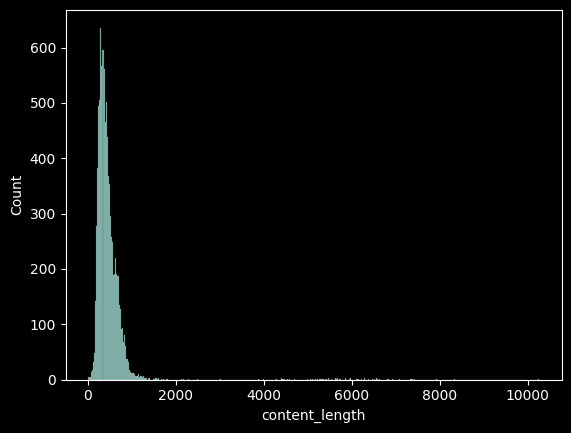

In [103]:
import seaborn as sns
cleaned_data["content_length"] = cleaned_data["content"].apply(lambda x: len(x))
sns.histplot(data=cleaned_data, x="content_length")

In [104]:
trash_mask = cleaned_data[(cleaned_data["content_length"] > 1000) & (cleaned_data["square"].isna())].index.values
cleaned_data.drop(trash_mask, inplace=True)

In [105]:
cleaned_data.columns

Index(['post_code', 'post_date', 'content', 'title', 'c_rent', 't_rent',
       'c_hurried', 't_hurried', 'district', 'price', 'square', 'bedroom',
       'bathroom', 'house_direction', 'has_balcony', 'has_furniture',
       'has_legal_info', 'is_hurried', 'floor', 'has_basement', 'house_type',
       'content_length'],
      dtype='object')

<h1><b>D. Xuất

In [106]:
cleaned_data.drop(['content', 'title', 'c_rent', 't_rent', 'c_hurried', 't_hurried', 'content_length'], axis=1, inplace=True)
price = cleaned_data['price']
cleaned_data.drop('price', axis=1, inplace=True)
cleaned_data['price'] = price

cleaned_data.to_csv('./dataset/csv_data/cleaned_data.csv', index=False, encoding="utf-8-sig")
print("Done!")

Done!
